In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

In [3]:
Weekly = load_data('Weekly')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


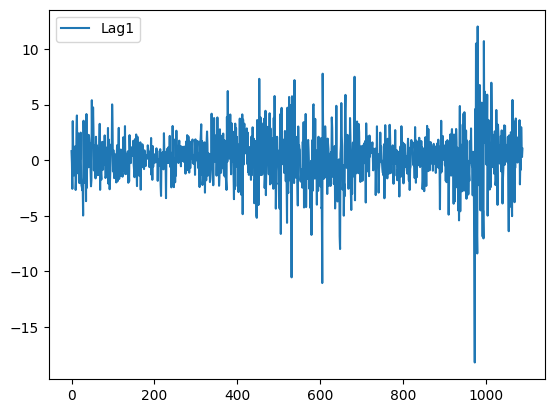

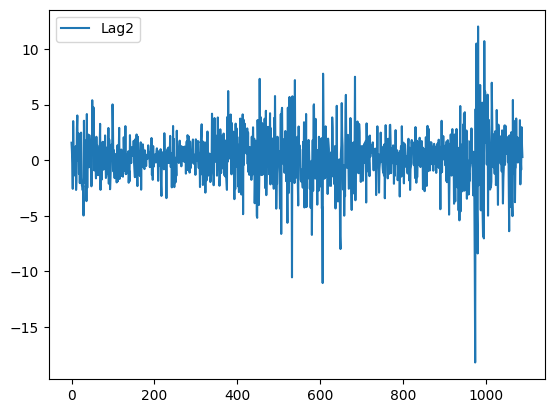

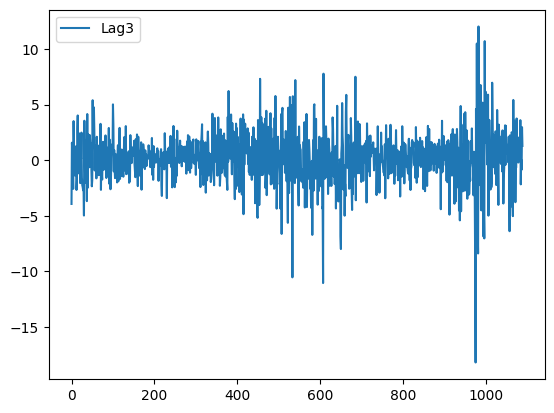

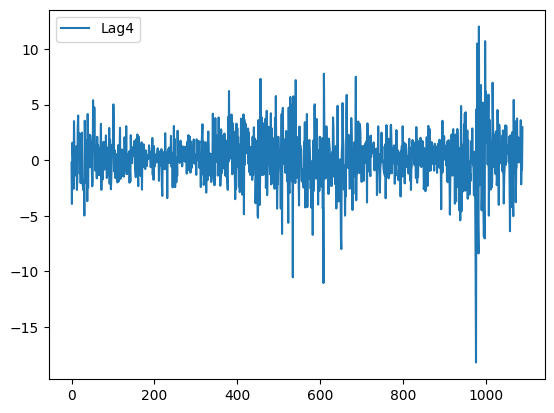

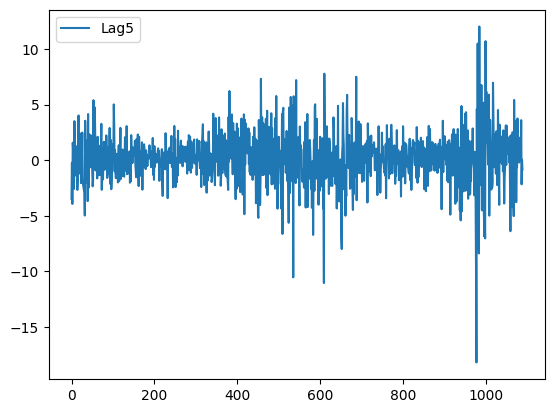

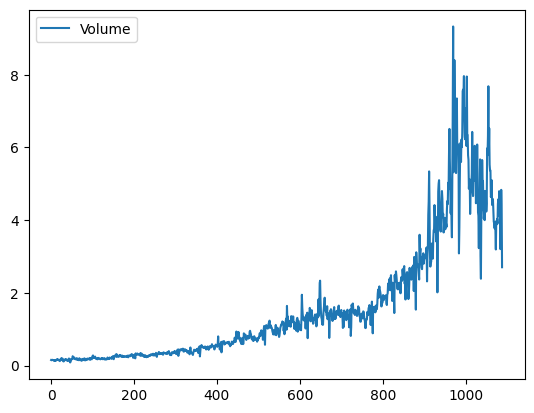

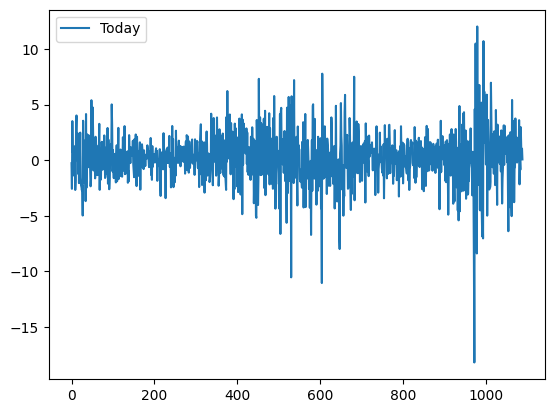

In [4]:
for col in Weekly.columns.drop(['Direction','Year']):
    Weekly.plot(y=col);

In [5]:
# We can see volumne has steadily increased, and around year 1950 there's high volatility in all the lags

# Predicting Direction based on Lag and Volumne
pred = Weekly.columns.drop(['Direction','Year','Today'])
design = MS(pred)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)
# The only statistically significant predictor is Lag2

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


In [6]:
# Creating a confusion table
probs = results.predict()
labels = np.array(['Down']*Weekly['Year'].count())
labels[probs > 0.5] = 'Up'
confusion_table(labels,Weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [7]:
# Overall fraction of correct predictions
(54+557)/(54+48+430+557)

0.5610651974288338

In [8]:
# Given we predict down we're right 53%
54/(54+48)

0.5294117647058824

In [9]:
# Given we predict Up, we're right 56%
557/(430+557)

0.5643363728470111

In [10]:
# Fitting logistic regression with Lag2 as only predictor on data between 1990 and 2008
pred = ['Lag2']
design = MS(pred)
# Splitting dataset
train = (Weekly.Year < 2009)
Weekly_train = Weekly.loc[train]
Weekly_test = Weekly.loc[~train]

X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]


In [11]:
# Creating a confusion table
labels = np.array(['Down']*Weekly_test['Year'].count())
labels[probs > 0.5] = 'Up'
confusion_table(labels,L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [12]:
# Test error rate: 62.5%
(9+56)/(9+5+34+56)

0.625

In [13]:
# Now we will perform LDA on the dataset before 2008
lda = LDA(store_covariance=True)

# LDA automaticaly adds an intercept, but we will remove it
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [14]:
# Note LDA and logistic regression predictions are identical
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,31,44
Up,12,17


In [15]:
# Using QDA
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,33,49
Up,10,12


In [16]:
# QDA just predicted everything would be up, leading to error rate 58%
61/(43+61)

0.5865384615384616

In [17]:
# Naive Bayes
NB = GaussianNB()
NB.fit(X_train, L_train)
# Making predictions
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)
# Naive bayes did the same as QDA

Truth,Down,Up
Predicted,,
Down,42,56
Up,1,5


In [18]:
# Using KNN with n=1
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,21,32
Up,22,29


In [19]:
# Error rate: 0.5
(21+31)/(21+30+22+31)

0.5

In [20]:
# LDA and Logistic regression performed the best on this dataset

In [34]:
# Fitting logistic regression with Lag1 and Lag2 as only predictor on data between 1990 and 2008
pred = ['Lag1','Lag2',('Lag1','Lag2')]
design = MS(pred)
#Splitting dataset

X = design.fit_transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]

glm_train = sm.GLM(y_train,
                   X_train,
                   family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2114,0.065,3.273,0.001
Lag1,-0.0515,0.031,-1.676,0.094
Lag2,0.0535,0.029,1.832,0.067
Lag1:Lag2,0.0019,0.007,0.257,0.797


In [31]:
# Creating a confusion table
labels = np.array(['Down']*Weekly_test['Year'].count())
labels[probs > 0.5] = 'Up'
confusion_table(labels,L_test)

Truth,Down,Up
Predicted,,
Down,7,8
Up,36,53
